# MEMO Assignment
Andrea De Carlo and Pooya Torabi

C:\Users\pooya\miniconda3\envs\Memo_DL2024\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
import requests
from PIL import Image

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


In [12]:
from torchvision import transforms

preaugment = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


out = preaugment(image)
out = preprocess(out)

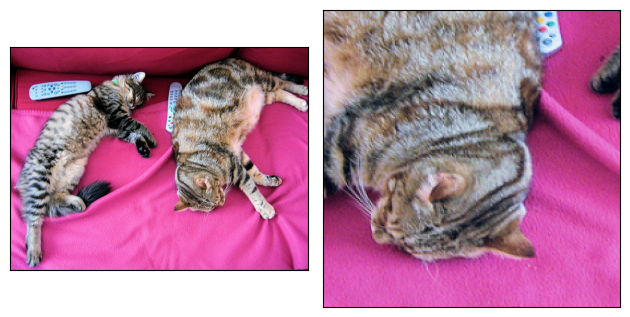

In [13]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    

plot([image, out])


In [14]:
import torch
import torchvision


# TODO read from aws s3 when on aws
# https://github.com/hendrycks/natural-adv-examples
imagenet_a_directory = 'datasets/imagenet-a'
# use target transformation for label changin if needed

# Dataset: ImageNet-A
# todo do we need to pass processor as transform?
imagenet_a = torchvision.datasets.ImageFolder(root=imagenet_a_directory,transform=torchvision.transforms.ToTensor())

In [15]:
from torch.utils.data import DataLoader

# batch size
BATCH_SIZE = 64

imagenet_a_dataloader = torch.utils.data.DataLoader(imagenet_a, batch_size=BATCH_SIZE, shuffle=True)

# is it needed?

In [16]:
import numpy as np
import torch.nn as nn


class MeanEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs):
        # compute mean entropy
        # todo needs to be tested
        logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
        avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
        min_real = torch.finfo(avg_logits.dtype).min
        avg_logits = torch.clamp(avg_logits, min=min_real)
        mean_entropy= -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits
        return mean_entropy


loss_fn = MeanEntropy()

In [17]:
augmentations = [preaugment]
    # # todo what are the augementation: AugMix
    # probably in utils.train_helpers.prepare_test_data

In [30]:
def memo_tta(pretrained_model, sample, optimizer):
    augmented_samples=[]
    # todo how to parallelize this
    print("came A")
    for augmentation in augmentations:
        augmented_sample = augmentation(sample)
        augmented_samples.append(augmented_sample)
        
    print("came B")

    output_distributions=[]
    
    pretrained_model.eval()
    for augmented_sample in augmented_samples:
        output_distribution = pretrained_model(augmented_sample)
        output_distributions.append(output_distribution)
        
    print("came C")

    
    loss = loss_fn(output_distributions)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print("came C")


    # todo Adapting BN statistics
    return pretrained_model

In [31]:
# todo what is the lr in paper
learning_rate = .1

fresh_pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).cuda()

def get_fresh_pretrained_model(): 
    pretrained_model = fresh_pretrained_model
    # in case multiple GPUs are available, this will try to utilize by Data Parallelism
    pretrained_model = nn.DataParallel(pretrained_model)
    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate)
    
    return pretrained_model, optimizer

In [33]:
# implementation of: test time adaptation via MEMO

# "only one gradient step per test point" as paper
epoch_for_adaptation = 1


for sample in imagenet_a:
    pretrained_model, optimizer = get_fresh_pretrained_model()
    adapted_model = None
    for epoch  in range(epoch_for_adaptation):
        adapted_model = memo_tta(pretrained_model, sample[0], optimizer)
    
    # inference phase
    with torch.no_grad():
        prediction = adapted_model(sample[0])
        # loss = loss_for_top_1_acc(prediction, sample['target'])
    # log inference accuracy

came A
came B


ValueError: You have to specify pixel_values